<a href="https://colab.research.google.com/github/tripfernandes/API-Mini-Project/blob/master/Part%202%20-%20EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import pytz
import numpy as np

In [2]:
# Fetch SPY data
spy = yf.Ticker('SPY')
spy_data = spy.history(period='max')

# Fetch SPY dividend data
spy_dividends = spy.dividends
spy_dividends_df = spy_dividends.reset_index()
spy_dividends_df.columns = ['Date', 'Dividend']
spy_dividends_df['Date'] = pd.to_datetime(spy_dividends_df['Date'])

# Convert SPY data index to 'US/Eastern' timezone if it's not already
if spy_data.index.tzinfo is None:
    spy_data.index = spy_data.index.tz_localize('US/Eastern')
else:
    spy_data.index = spy_data.index.tz_convert('US/Eastern')

# Merge SPY data with dividend data
spy_data = pd.merge(spy_data.reset_index(), spy_dividends_df, left_on='Date', right_on='Date', how='left')

# Fill missing dividend values with 0
spy_data['Dividend'] = spy_data['Dividend'].fillna(0)

# Calculate normalized value with DRIP
initial_investment = 10000
spy_data['normalized_value'] = float(initial_investment)

# Calculate normalized value
for i in range(1, len(spy_data)):
    dividend = spy_data.loc[spy_data.index[i], 'Dividend']
    price_today = spy_data.loc[spy_data.index[i], 'Close']
    price_yesterday = spy_data.loc[spy_data.index[i-1], 'Close']
    shares_today = spy_data.loc[spy_data.index[i-1], 'normalized_value'] / price_yesterday
    if dividend > 0:
        shares_today += (dividend / price_today)
    spy_data.loc[spy_data.index[i], 'normalized_value'] = float(shares_today * price_today)

# Normalize SPY portfolio for comparison
spy_data['normalized_value'] = (spy_data['Close'] / spy_data['Close'].iloc[0]) * initial_investment

# Reset index and handle missing columns
spy_data['Date'] = pd.to_datetime(spy_data['Date'])
spy_data.set_index('Date', inplace=True)
spy_data['Date_as_Index'] = spy_data.index
spy_data.reset_index(inplace=True)
spy_data.set_index('Date_as_Index', inplace=True)

print(spy_data.tail())
print(spy_data.columns)
print(spy_data.index)

                                               Date        Open        High  \
Date_as_Index                                                                 
2024-08-22 00:00:00-04:00 2024-08-22 00:00:00-04:00  562.559998  563.179993   
2024-08-23 00:00:00-04:00 2024-08-23 00:00:00-04:00  559.530029  563.090027   
2024-08-26 00:00:00-04:00 2024-08-26 00:00:00-04:00  563.179993  563.909973   
2024-08-27 00:00:00-04:00 2024-08-27 00:00:00-04:00  559.489990  562.059998   
2024-08-28 00:00:00-04:00 2024-08-28 00:00:00-04:00  561.210022  561.642029   

                                  Low       Close    Volume  Dividends  \
Date_as_Index                                                            
2024-08-22 00:00:00-04:00  554.979980  556.219971  56121500        0.0   
2024-08-23 00:00:00-04:00  557.289978  562.130005  50639400        0.0   
2024-08-26 00:00:00-04:00  559.049988  560.789978  35788600        0.0   
2024-08-27 00:00:00-04:00  558.320007  561.559998  32627800        0.0   
20

In [3]:
portfolio_div = ['PG', 'GPC', 'EMR', 'CINF', 'KO', 'CL', 'MO', 'FRT', 'PPG', 'TROW']

all_dividends = pd.DataFrame()

for symbol in portfolio_div:
    try:
        stock = yf.Ticker(symbol)

        # Fetch historical price data
        price_data = stock.history(start='1993-01-29', end='2023-12-31')
        price_data.reset_index(inplace=True)
        price_data['symbol'] = symbol  # Ensure 'symbol' column is in price_data

        # Fetch historical dividend data
        dividend_data = stock.dividends
        dividend_data.name = symbol
        dividend_data = dividend_data.reset_index()
        dividend_data.columns = ['Date', 'Dividend']
        dividend_data['Date'] = pd.to_datetime(dividend_data['Date'])
        dividend_data['symbol'] = symbol

        # Fetch historical stock splits data
        split_data = stock.splits
        split_data.name = 'Stock Splits'
        split_data = split_data.reset_index()
        split_data.columns = ['Date', 'Stock Splits']
        split_data['Date'] = pd.to_datetime(split_data['Date'])
        split_data['symbol'] = symbol

        # Merge price data and dividend data first
        combined_data = pd.merge(price_data, dividend_data, how='left', on=['Date', 'symbol'])

        # Merge stock splits data
        if not split_data.empty:
            combined_data = pd.merge(combined_data, split_data, how='left', on=['Date', 'symbol'])
        else:
            # If no splits, add Stock Splits column with NaNs
            combined_data['Stock Splits'] = np.nan

        # Adjust historical prices and dividends for stock splits if splits data exists
        if 'Stock Splits' in combined_data.columns:
            combined_data['Adj Close'] = combined_data['Close']
            combined_data['Adj Dividend'] = combined_data['Dividend']

            for i in range(1, len(combined_data)):
                if pd.notna(combined_data.at[i, 'Stock Splits']) and combined_data.at[i, 'Stock Splits'] != 0:
                    ratio = combined_data.at[i, 'Stock Splits']
                    combined_data.loc[:i-1, 'Adj Close'] /= ratio
                    combined_data.loc[:i-1, 'Adj Dividend'] /= ratio

        all_dividends = pd.concat([all_dividends, combined_data], ignore_index=True)

    except Exception as e:
        print(f"Failed to get data for {symbol}: {e}")

# Ensure the 'Date' column is in datetime format
all_dividends['Date'] = pd.to_datetime(all_dividends['Date'])

# Ensure column cleanup after merges
if 'Stock Splits_x' in all_dividends.columns and 'Stock Splits_y' in all_dividends.columns:
    all_dividends.rename(columns={'Stock Splits_x': 'Stock Splits Price', 'Stock Splits_y': 'Stock Splits Dividend'}, inplace=True)
    # Drop one if not needed
    all_dividends.drop(columns=['Stock Splits Dividend'], inplace=True)

# Adding DRIP logic
dripped_symbols = {'PG', 'GPC', 'EMR', 'CINF', 'KO', 'CL', 'MO', 'FRT', 'PPG', 'TROW'}
all_dividends['DRIP'] = all_dividends['symbol'].apply(lambda x: 'yes' if x in dripped_symbols else 'no')

# Calculate reinvested dividends
all_dividends['Reinvested_Dividends'] = all_dividends.apply(
    lambda row: row['Dividend'] if row['DRIP'] == 'yes' else 0, axis=1
)

# Calculate additional shares purchased from reinvested dividends
all_dividends['Additional_Shares'] = all_dividends['Reinvested_Dividends'] / all_dividends['Close']

# Calculate cumulative total shares for each stock symbol
all_dividends['Total_Shares'] = all_dividends.groupby('symbol')['Additional_Shares'].cumsum()

# Initial investment assumption (adjust as needed)
initial_investment = 10000

# Calculate initial shares bought with initial investment
all_dividends['Initial_Shares'] = initial_investment / all_dividends.groupby('symbol')['Close'].transform('first')

# Calculate the portfolio value
all_dividends['Portfolio_Value'] = all_dividends['Initial_Shares'] * all_dividends['Close'] + all_dividends['Total_Shares'] * all_dividends['Close']


# Reset index and handle missing columns
all_dividends['Date'] = pd.to_datetime(all_dividends['Date'])
all_dividends.set_index('Date', inplace=True)
all_dividends['Date_as_Index'] = all_dividends.index
all_dividends.reset_index(inplace=True)
all_dividends.set_index('Date_as_Index', inplace=True)

if all_dividends.index.tzinfo is None:
    all_dividends.index = all_dividends.index.tz_localize('US/Eastern')
else:
    all_dividends.index = all_dividends.index.tz_convert('US/Eastern')

# Check the DataFrame
print(all_dividends.head())
print(all_dividends.columns)
print(all_dividends.index)

                                               Date      Open      High  \
Date_as_Index                                                             
1993-01-29 00:00:00-05:00 1993-01-29 00:00:00-05:00  5.788132  5.802531   
1993-02-01 00:00:00-05:00 1993-02-01 00:00:00-05:00  5.759336  5.802531   
1993-02-02 00:00:00-05:00 1993-02-02 00:00:00-05:00  5.759337  5.816930   
1993-02-03 00:00:00-05:00 1993-02-03 00:00:00-05:00  5.788135  5.845728   
1993-02-04 00:00:00-05:00 1993-02-04 00:00:00-05:00  5.860125  5.888922   

                                Low     Close   Volume  Dividends  \
Date_as_Index                                                       
1993-01-29 00:00:00-05:00  5.716141  5.730539  4040000        0.0   
1993-02-01 00:00:00-05:00  5.730539  5.788132  3292400        0.0   
1993-02-02 00:00:00-05:00  5.759337  5.759337  2364400        0.0   
1993-02-03 00:00:00-05:00  5.788135  5.831330  2091600        0.0   
1993-02-04 00:00:00-05:00  5.802532  5.860125  3082800      

In [7]:
# Define initial investment amount and number of stocks
initial_investment_per_stock = 10000 / len(all_dividends['symbol'].unique())

# Initialize a DataFrame to hold portfolio values
all_dividends['normalized_value'] = 0

# Calculate initial shares for each stock
for symbol in all_dividends['symbol'].unique():
    stock_data = all_dividends[all_dividends['symbol'] == symbol]
    initial_shares = initial_investment_per_stock / stock_data['Close'].iloc[0]
    stock_data['normalized_value'] = initial_shares * stock_data['Close'] + stock_data.groupby('Date')['Dividends'].cumsum() * initial_shares
    all_dividends.loc[all_dividends['symbol'] == symbol, 'normalized_value'] = stock_data['normalized_value']

# Aggregate the total value of all dividend stocks
dividend_portfolio = all_dividends.groupby('Date')['normalized_value'].sum().reset_index()
dividend_portfolio.rename(columns={'normalized_value': 'Total_Value'}, inplace=True)

# Calculate total return as a percentage
initial_value_dividends = dividend_portfolio['Total_Value'].iloc[0]
dividend_portfolio['Total_Return'] = (dividend_portfolio['Total_Value'] / initial_value_dividends - 1) * 100

<ipython-input-7-48b9d8db8437>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['normalized_value'] = initial_shares * stock_data['Close'] + stock_data.groupby('Date')['Dividends'].cumsum() * initial_shares
<ipython-input-7-48b9d8db8437>:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1000.          1010.05024958  1005.02537442 ... 25015.10067016
 24958.58189149 25097.30665593]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  all_dividends.loc[all_dividends['symbol'] == symbol, 'normalized_value'] = stock_data['normalized_value']


In [8]:
# Ensure both DataFrames have the same date range
start_date = max(dividend_portfolio['Date'].min(), spy_data.index.min())
end_date = min(dividend_portfolio['Date'].max(), spy_data.index.max())

dividend_portfolio = dividend_portfolio[(dividend_portfolio['Date'] >= start_date) & (dividend_portfolio['Date'] <= end_date)]
spy_data = spy_data[(spy_data.index >= start_date) & (spy_data.index <= end_date)]

# Normalize SPY portfolio for comparison
initial_investment = 10000
spy_data['normalized_value'] = (spy_data['Close'] / spy_data['Close'].iloc[0]) * initial_investment

# Calculate total return as a percentage
initial_value = spy_data['normalized_value'].iloc[0]
spy_data['Total_Return'] = (spy_data['normalized_value'] / initial_value - 1) * 100

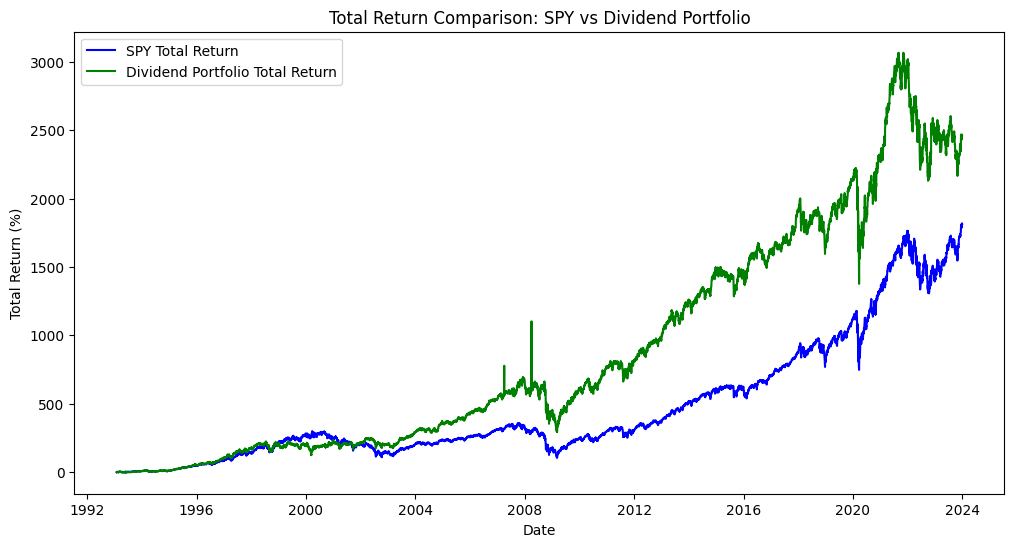

In [10]:
plt.figure(figsize=(12, 6))

# Plot SPY total return
plt.plot(spy_data.index, spy_data['Total_Return'], label='SPY Total Return', color='blue')

# Plot Dividend Portfolio total return
plt.plot(dividend_portfolio['Date'], dividend_portfolio['Total_Return'], label='Dividend Portfolio Total Return', color='green')

plt.title('Total Return Comparison: SPY vs Dividend Portfolio')
plt.xlabel('Date')
plt.ylabel('Total Return (%)')
plt.legend()
plt.show()

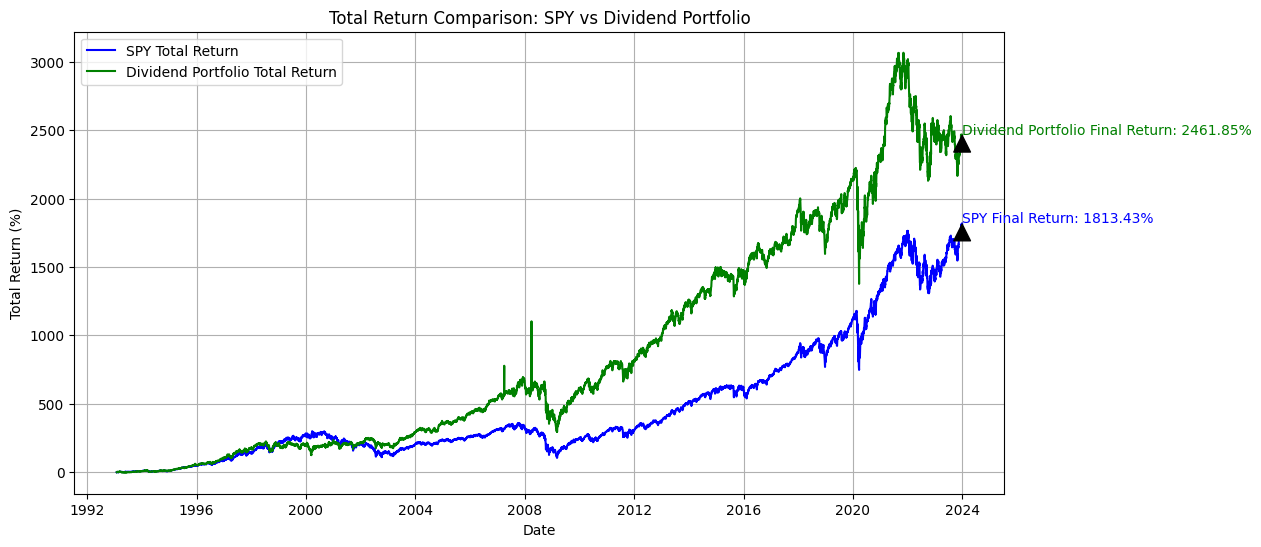

In [11]:

# Determine the end date for annotation
end_date = spy_data.index[-1]

# Extract the final total return values
spy_final_return = spy_data.loc[end_date, 'Total_Return']
dividend_final_return = dividend_portfolio.loc[dividend_portfolio['Date'] == end_date, 'Total_Return'].values[0]

plt.figure(figsize=(12, 6))

# Plot SPY total return
plt.plot(spy_data.index, spy_data['Total_Return'], label='SPY Total Return', color='blue')

# Plot Dividend Portfolio total return
plt.plot(dividend_portfolio['Date'], dividend_portfolio['Total_Return'], label='Dividend Portfolio Total Return', color='green')

# Annotate final total return values
plt.annotate(f'SPY Final Return: {spy_final_return:.2f}%',
             xy=(end_date, spy_final_return),
             xytext=(end_date, spy_final_return + 10),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=10, color='blue')

plt.annotate(f'Dividend Portfolio Final Return: {dividend_final_return:.2f}%',
             xy=(end_date, dividend_final_return),
             xytext=(end_date, dividend_final_return + 10),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=10, color='green')

plt.title('Total Return Comparison: SPY vs Dividend Portfolio')
plt.xlabel('Date')
plt.ylabel('Total Return (%)')
plt.legend()
plt.grid(True)
plt.show()

SPY Data Columns: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits', 'Capital Gains', 'Dividend', 'normalized_value',
       'Total_Return'],
      dtype='object')
Dividend Portfolio Columns: Index(['Date', 'Total_Value', 'Total_Return', 'Portfolio_Value'], dtype='object')


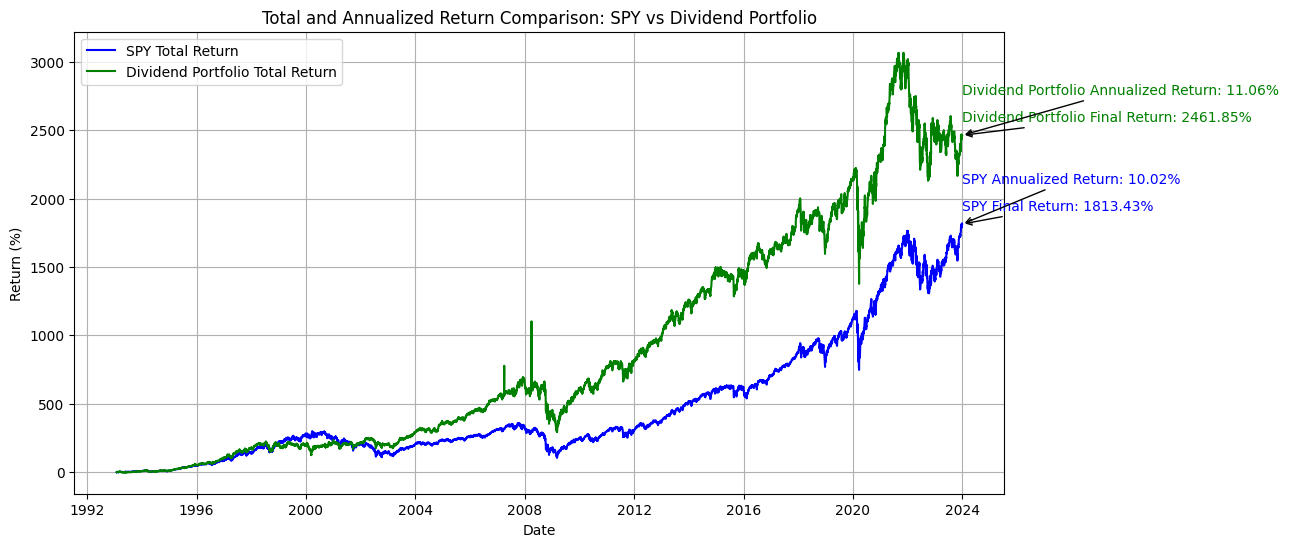

In [24]:
# Ensure the necessary columns exist
print("SPY Data Columns:", spy_data.columns)
print("Dividend Portfolio Columns:", dividend_portfolio.columns)

# Ensure 'Total_Return' columns are calculated correctly
if 'Total_Return' not in spy_data.columns:
    spy_data['Total_Return'] = (spy_data['normalized_value'] / spy_data['normalized_value'].iloc[0] - 1) * 100

if 'Total_Return' not in dividend_portfolio.columns:
    dividend_portfolio['Total_Return'] = (dividend_portfolio['Portfolio_Value'] / dividend_portfolio['Portfolio_Value'].iloc[0] - 1) * 100

# Re-calculate total return percentage for both portfolios (for correct values)
spy_final_value = spy_data['normalized_value'].iloc[-1]
spy_initial_value = spy_data['normalized_value'].iloc[0]
spy_total_return = (spy_final_value / spy_initial_value - 1) * 100

dividend_final_value = dividend_portfolio['Portfolio_Value'].iloc[-1]
dividend_initial_value = dividend_portfolio['Portfolio_Value'].iloc[0]
dividend_total_return = (dividend_final_value / dividend_initial_value - 1) * 100

# Calculate the number of years for annualized return
start_date = spy_data.index[0]
end_date = spy_data.index[-1]
years = (end_date - start_date).days / 365.25

# Calculate annualized returns
spy_annualized_return = (spy_final_value / spy_initial_value) ** (1 / years) - 1
dividend_annualized_return = (dividend_final_value / dividend_initial_value) ** (1 / years) - 1

# Convert annualized returns to percentages
spy_annualized_return *= 100
dividend_annualized_return *= 100

# Plot the returns
plt.figure(figsize=(12, 6))

# Plot SPY total return
plt.plot(spy_data.index, spy_data['Total_Return'], label='SPY Total Return', color='blue')

# Plot Dividend Portfolio total return
plt.plot(dividend_portfolio['Date'], dividend_portfolio['Total_Return'], label='Dividend Portfolio Total Return', color='green')

# Annotate final total return values and annualized returns
plt.annotate(f'SPY Final Return: {spy_total_return:.2f}%',
             xy=(spy_data.index[-1], spy_data['Total_Return'].iloc[-1]),
             xytext=(spy_data.index[-1], spy_data['Total_Return'].iloc[-1] + 100),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10, color='blue')

plt.annotate(f'SPY Annualized Return: {spy_annualized_return:.2f}%',
             xy=(spy_data.index[-1], spy_data['Total_Return'].iloc[-1]),
             xytext=(spy_data.index[-1], spy_data['Total_Return'].iloc[-1] + 300),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10, color='blue')

plt.annotate(f'Dividend Portfolio Final Return: {dividend_total_return:.2f}%',
             xy=(dividend_portfolio['Date'].iloc[-1], dividend_portfolio['Total_Return'].iloc[-1]),
             xytext=(dividend_portfolio['Date'].iloc[-1], dividend_portfolio['Total_Return'].iloc[-1] + 100),
             arrowprops=dict(facecolor='blue', arrowstyle='->'),
             fontsize=10, color='green')

plt.annotate(f'Dividend Portfolio Annualized Return: {dividend_annualized_return:.2f}%',
             xy=(dividend_portfolio['Date'].iloc[-1], dividend_portfolio['Total_Return'].iloc[-1]),
             xytext=(dividend_portfolio['Date'].iloc[-1], dividend_portfolio['Total_Return'].iloc[-1] + 300),
             arrowprops=dict(facecolor='green', arrowstyle='->'),
             fontsize=10, color='green')

plt.title('Total and Annualized Return Comparison: SPY vs Dividend Portfolio')
plt.xlabel('Date')
plt.ylabel('Return (%)')
plt.legend()
plt.grid(True)
plt.show()